In [17]:
# 数据加载
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 加载数据
file_path = 'data/summerOly_athletes_total_with_types.csv'
data = pd.read_csv(file_path)

# 获取独特的运动项目、年份和代表队
sports = sorted(data['Type'].unique())  # 运动项目 S
years = sorted(data['Year'].unique())   # 奥运会年份 T
nocs = sorted(data['NOC'].unique())     # 国家代表队 N
S, T, N = len(sports), len(years), len(nocs)

# 构建映射表
sport_to_idx = {sport: i for i, sport in enumerate(sports)}
year_to_idx = {year: i for i, year in enumerate(years)}
noc_to_idx = {noc: i for i, noc in enumerate(nocs)}
print(sport_to_idx)
print(noc_to_idx)
print(year_to_idx)

# 加载结果张量
output_path = 'data/olympic_medals_with_type.npy'
result_tensor = np.load(output_path)
# 对year维度进行累加，即计算每个国家每个运动项目在之前历届奥运会中的累计牌数
cumulative_medals = np.cumsum(result_tensor, axis=1)


{'Artistic Sports': 0, 'Athletics': 1, 'Combat Sports': 2, 'Cycling Sports': 3, 'Endurance Sports': 4, 'Equestrian': 5, 'Extreme Sports': 6, 'Gymnastics': 7, 'Other Traditional Sports': 8, 'Racket Sports': 9, 'Small Ball Sports': 10, 'Team Ball Sports': 11, 'Water Sports': 12, 'Weapon Sports': 13, 'Winter Sports': 14}
{'AFG': 0, 'AHO': 1, 'AIN': 2, 'ALB': 3, 'ALG': 4, 'AND': 5, 'ANG': 6, 'ANT': 7, 'ANZ': 8, 'ARG': 9, 'ARM': 10, 'ARU': 11, 'ASA': 12, 'AUS': 13, 'AUT': 14, 'AZE': 15, 'BAH': 16, 'BAN': 17, 'BAR': 18, 'BDI': 19, 'BEL': 20, 'BEN': 21, 'BER': 22, 'BHU': 23, 'BIH': 24, 'BIZ': 25, 'BLR': 26, 'BOH': 27, 'BOL': 28, 'BOT': 29, 'BRA': 30, 'BRN': 31, 'BRU': 32, 'BUL': 33, 'BUR': 34, 'CAF': 35, 'CAM': 36, 'CAN': 37, 'CAY': 38, 'CGO': 39, 'CHA': 40, 'CHI': 41, 'CHN': 42, 'CIV': 43, 'CMR': 44, 'COD': 45, 'COK': 46, 'COL': 47, 'COM': 48, 'CPV': 49, 'CRC': 50, 'CRO': 51, 'CRT': 52, 'CUB': 53, 'CYP': 54, 'CZE': 55, 'DEN': 56, 'DJI': 57, 'DMA': 58, 'DOM': 59, 'ECU': 60, 'EGY': 61, 'EOR': 

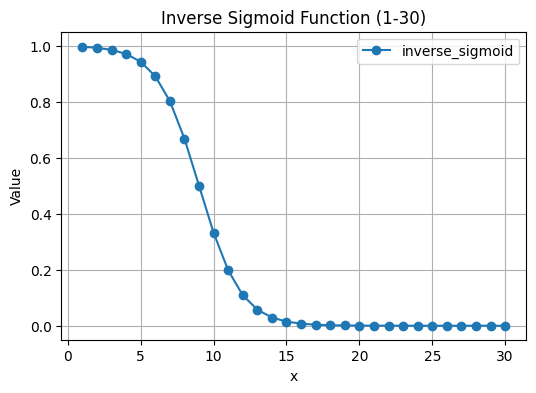

In [18]:
import torch
import matplotlib.pyplot as plt

def inverse_sigmoid(x, k=-0.7, c=22):
    """
    将 1 到 30 的整数映射到 0 到 1 范围内，并呈现反 sigmoid 函数的单调递减趋势。
    :param x: 输入值 (torch.Tensor)
    :param k: 控制曲线陡峭程度
    :param c: 控制曲线中心点
    :return: 映射到 0 到 1 范围内的值
    """
    return 1 / (1 + torch.exp(k * ((31 - x) - c)))

# 生成 x 在 [1, 30] 整数范围内的取值
x = torch.arange(1, 31, dtype=torch.float32)
# 计算对应的 y
y = inverse_sigmoid(x)

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o', label='inverse_sigmoid')
plt.title('Inverse Sigmoid Function (1-30)')
plt.xlabel('x')
plt.ylabel('Value')
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()


In [19]:

# 创建权重，权重随着时间递增（非线性）
def inverse_sigmoid(x, k=-0.7, c=22):
    """
    将 1 到 30 的整数映射到 0 到 1 范围内，并呈现反 sigmoid 函数的单调递减趋势。
    :param x: 输入值 (torch.Tensor)
    :param k: 控制曲线陡峭程度
    :param c: 控制曲线中心点
    :return: 映射到 0 到 1 范围内的值
    """
    return 1 / (1 + torch.exp(k * (x - c)))



In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# total = 0
# # 遍历每个项目
# for idx in range(S):


                          1900  1904  1906  1908  1912  1920  1928  1932  \
Type                                                                       
Athletics                   23    25    21    26    30    29  27.0  29.0   
Combat Sports                0    14     4    14     5    18  21.0  22.0   
Cycling Sports               3     7     6     7     2     6   6.0   6.0   
Endurance Sports             2     2     0     0     0     5   5.0   5.0   
Equestrian                   5     0     0     0     5     7   6.0   6.0   
Extreme Sports               0     0     0     0     0     0   0.0   0.0   
Gymnastics                   1    11     4     2     4     4   8.0  11.0   
Other Traditional Sports    19     2     1     8     6    16   4.0   5.0   
Racket Sports                5     2     4    10     8     6   0.0   0.0   
Small Ball Sports            2     2     0     0     0     0   0.0   0.0   
Team Ball Sports             3     3     1     5     2     4   3.0   2.0   
Water Sports

In [28]:

idx = 0

# ===============================
#  数据准备
# 累计奖牌数
Cum = cumulative_medals[idx].T
# 按所有国家到每一届的累计奖牌数归一化(需要考虑分母为0的情况)
Cum_normalized = Cum / (Cum.sum(axis=0) + 1e-7)

# 国家派出的运动员数量
sport_to_idx_inv = {v: k for k, v in sport_to_idx.items()}
sport = sport_to_idx_inv[idx]
file_path = f'data/athletes_count/{sport}.csv'
athletes_count = pd.read_csv(file_path)
# 列索引中年份并不是顺序的，需要重新排序
years = sorted(athletes_count.columns)
athletes_count = athletes_count[years]
# 重新组织列表，使其行的顺序与noc_to_idx一致
athletes_count.set_index(athletes_count.columns[-1], inplace=True)
athletes_count = athletes_count.reindex(nocs)
athletes_count.reset_index(inplace=True)
Num = (athletes_count.values)[:, 1:]

# 每届总项目数量

# 读取CSV文件
file_path = "data/summerOly_programs_with_types.csv"  # 替换为实际文件路径
data = pd.read_csv(file_path)
# 提取年份列(years = sorted(athletes_count.columns))
# 按Type分组并统计每一年的项目总和
type_totals = data.groupby("Type")[years[:-1]].sum()

print(type_totals)

# 国家在该届奥运会的奖牌数
Medal = result_tensor[idx].T

i_count, j_count = Num.shape

# 计算时间加权
weights = inverse_sigmoid(torch.tensor(range(1, j_count + 1)), k=-0.7, c=20).numpy()



                          1900  1904  1906  1908  1912  1920  1928  1932  \
Type                                                                       
Athletics                   23    25    21    26    30    29  27.0  29.0   
Combat Sports                0    14     4    14     5    18  21.0  22.0   
Cycling Sports               3     7     6     7     2     6   6.0   6.0   
Endurance Sports             2     2     0     0     0     5   5.0   5.0   
Equestrian                   5     0     0     0     5     7   6.0   6.0   
Extreme Sports               0     0     0     0     0     0   0.0   0.0   
Gymnastics                   1    11     4     2     4     4   8.0  11.0   
Other Traditional Sports    19     2     1     8     6    16   4.0   5.0   
Racket Sports                5     2     4    10     8     6   0.0   0.0   
Small Ball Sports            2     2     0     0     0     0   0.0   0.0   
Team Ball Sports             3     3     1     5     2     4   3.0   2.0   
Water Sports

In [ ]:


# ==================================
#  预测

# 创建特征矩阵和目标变量
data = []
for i in range(i_count):
    for j in range(j_count):
        data.append([
            Cum_normalized[i, j],
            Num[i, j],
            # Event[j],
            Medal[i, j],
            weights[j],  # 时间加权
        ])
data = pd.DataFrame(data, columns=["Cum", "Num", "Medal", "Weight"])

# 特征和目标变量
X = data[["Cum", "Num"]]
y = data["Medal"]

# 加权时间权重应用
sample_weights = data["Weight"]

# 归一化特征矩阵
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 训练加权线性回归模型
model = LinearRegression()
model.fit(X_scaled, y, sample_weight=sample_weights)

# # 输出回归模型的系数和截距
print("回归系数:", model.coef_)
print("截距:", model.intercept_)


# 预测 2024 年的奖牌数量
noc = "CHN"
noc_idx = noc_to_idx[noc]
# 2024 年的索引
year_idx = year_to_idx[2024]
# 2024 年的累计奖牌数归一化值
cum_normalized_2024 = Cum_normalized[noc_idx, year_idx]
# 2024 年的国家派出的运动员数量
num_2024 = Num[noc_idx, year_idx]
# 预测值
predicted_medal_2024 = model.predict([[cum_normalized_2024, num_2024]])[0]

